In [1]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for nicer plots
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("APL_Logistics_features.csv")
print("Data loaded. Shape:", df.shape)

# Define target
y = (df['Late_delivery_risk'] > 0).astype(int)
print("Target distribution:\n", y.value_counts())


Data loaded. Shape: (180519, 35)
Target distribution:
 1    98977
0    81542
Name: Late_delivery_risk, dtype: int64


In [3]:
# Load the exact feature columns used in training
feature_columns = joblib.load("feature_columns.pkl")
print("Features used for training:", feature_columns)


Features used for training: ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Category Name', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Department Name', 'Market', 'Order City', 'Order Country', 'Order Region', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Price', 'Shipping_Pressure_Index', 'Shipping_Mode_Express', 'Regional_Congestion_Index', 'Order_Complexity_Score']


In [4]:
# Keep only columns used during training
X = df[feature_columns]
print("X shape after alignment:", X.shape)


X shape after alignment: (180519, 27)


In [5]:
xgb_clf = joblib.load("APL_Logistics_best_model_xgb.pkl")
print("XGBoost model loaded successfully")


XGBoost model loaded successfully


In [6]:
y_pred = xgb_clf.predict(X)
y_proba = xgb_clf.predict_proba(X)[:,1]  # probability for ROC-AUC


Confusion Matrix:
[[77234  4308]
 [    2 98975]]


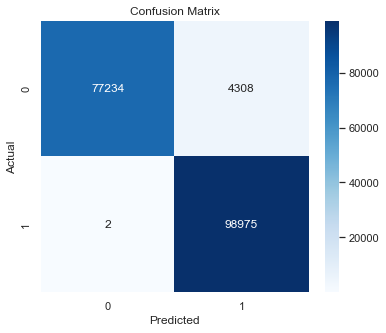

In [7]:
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
print("Classification Report:")
print(classification_report(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     81542
           1       0.96      1.00      0.98     98977

    accuracy                           0.98    180519
   macro avg       0.98      0.97      0.98    180519
weighted avg       0.98      0.98      0.98    180519



ROC-AUC Score: 0.9934392737287945


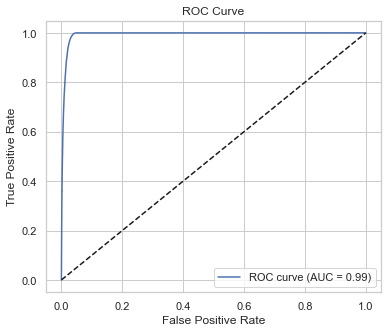

In [9]:
roc_auc = roc_auc_score(y, y_proba)
print("ROC-AUC Score:", roc_auc)

# ROC curve plot
fpr, tpr, thresholds = roc_curve(y, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [10]:
eval_results = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred,
    "y_proba": y_proba
})
eval_results.to_csv("APL_Logistics_model_eval.csv", index=False)
print("Evaluation results saved to APL_Logistics_model_eval.csv")


Evaluation results saved to APL_Logistics_model_eval.csv


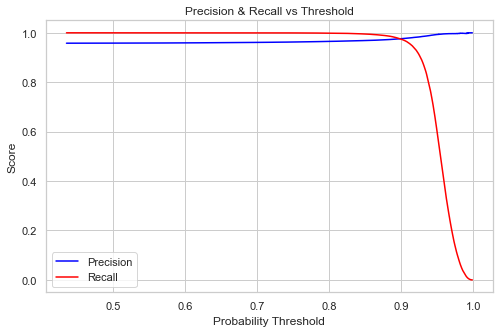

In [11]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y, y_proba)

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Example: choose threshold where precision ~ recall ~ 0.95
best_idx = (np.abs(precision - recall)).argmin()
best_threshold = thresholds[best_idx]
print(f"Suggested threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}")

# Apply new threshold
y_pred_threshold = (y_proba >= best_threshold).astype(int)
print("Confusion matrix at new threshold:")
print(confusion_matrix(y, y_pred_threshold))


NameError: name 'np' is not defined